In [1]:
#Test notebook for tracking rigid body  marker consisting of multiple fiducials within a CT scan volume

#3D data processing
import open3d as o3d
import ct_tracking_library # our helper functions
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from ipywidgets import interact, fixed


import tqdm

#our processing code
from ct_tracking_library.ct_tracking_functions import *
from ct_tracking_library.ct_processing_functions import *
from ct_tracking_library.ct_display_functions import *

#used for GUI
%matplotlib notebook


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


C:\Users\snowl\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Feltch the DICOM file from server

### Goto the website:  http://unicorn2.ucsd.edu:8080/dcm4chee-arc/ui2/#/study/patient

### Selected Series on the top tabs

### On the left hand side input: DIMITRI07041995 as the Patient ID

### In the middle section select Newest Frist in the Order by Tab

### In the middle section select DCM4CHEE in the Web App Service Tab and CLICK Sumbit

### Download the 1st row by clicking the 3 dots symbol and downolad it

### Once Downloaded, extract the DICOM file folder ONLY to the following folder: ./test_data

## Load marker geometry

In [2]:
target_marker_name = 'moving_marker_crane'

if target_marker_name == 'fixed_marker_crane':
    marker = np.load('./test_data/marker1.npy')
    #R =  t3d.euler.euler2mat(np.pi/4+0.1, 0, -np.pi/6-0.2)@t3d.euler.euler2mat(0,0.6,0)# @ t3d.euler.euler2mat(0, np.pi/8, 0)
    #marker = (R.T@marker.T).T
    crop_z = None
    #zero mean the marker since we place the rigid body at the mean here
    marker = marker - marker.mean(axis=0) - np.array([2,0,0])
if target_marker_name == 'moving_marker_crane':
    marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
    R = np.eye(3)
    crop_z = None

if target_marker_name == 'moving_marker_1_DoF':
    marker = np.array([[-10,-5,0],[-10,5,0],[0,-5,0],[10,0,0]])
    R = np.eye(3)
    crop_z = None

if target_marker_name == 'fixed_marker_1_DoF':
    marker = np.array([[0,-14,0],[0,-6,0],[0,16,0],[17,0,0]])
    R = np.eye(3)
    crop_z = [160,254]
    
print('Our marker: \n {}'.format(marker))

Our marker: 
 [[-10  -5   0]
 [-10   5   0]
 [  0  -5   0]
 [ 10   0   0]]


## Processing DICOM file

In [3]:
transforms = []
visualizations = []

In [4]:
def DICOM_series_dropdown_callback(series_to_load, series_dictionary):
    global selected_series
               # Print some information about the series from the meta-data dictionary
               # DICOM standard part 6, Data Dictionary: http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf
    file_reader.SetFileName(series_dictionary[series_to_load][0])
    file_reader.ReadImageInformation()
    tags_to_print = {'0010|0010': 'Patient name: ', 
                     '0008|0060' : 'Modality: ',
                     '0008|0021' : 'Series date: ',
                     '0008|0080' : 'Institution name: ',
                     '0008|1050' : 'Performing physician\'s name: '}
    for tag in tags_to_print:
        try:
            print(tags_to_print[tag] + file_reader.GetMetaData(tag))
        except: # Ignore if the tag isn't in the dictionary
            pass
    selected_series = series_to_load

In [5]:
scan_files_CRANE = ['./test_data/90FA4003/1F59163E', './test_data/90FA4003/38AF3F19', 
                  './test_data/90FA4003/BDF1B64C', './test_data/90FA4003/2219F7F7', 
                    './test_data/90FA4003/863148B2', './test_data/90FA4003/C7AAA9F9', './test_data/90FA4003/975D3E7B', './test_data/90FA4003/863148B2']
#scan_file_CRANE = scan_files_CRANE[-2]
scan_file_1DoF = './test_data/90FA4003/52C2B62A'

In [6]:
data_directory = scan_files_CRANE[-1]
print(data_directory)
# Global variable 'selected_series' is updated by the interact function
selected_series = ''
file_reader = sitk.ImageFileReader()         
# Directory contains multiple DICOM studies/series, store
# in dictionary with key being the series ID
series_file_names = {}
series_IDs = sitk.ImageSeriesReader_GetGDCMSeriesIDs(data_directory)
            # Check that we have at least one series
if series_IDs:
    for series in series_IDs:
        series_file_names[series] = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(data_directory, series)
    
    interact(DICOM_series_dropdown_callback, series_to_load=list(series_IDs), series_dictionary=fixed(series_file_names)); 
else:
    print('Data directory does not contain any DICOM series.')

./test_data/90FA4003/863148B2


interactive(children=(Dropdown(description='series_to_load', options=('1.2.840.113619.2.416.973064298079076658…

In [7]:
import pyvista as pv
import mcubes

In [8]:
# def convert_mha_to_mesh(mha_file='temp_mesh.mha', output_mesh_file = 'temp_mesh.obj', threshold_value = 2000, odir='', debug=False):
#     '''
#     input:
#         mha_file: DICOM data containing the sapcing deimesion
#         output_mesh_file: file name for storing the output thresholded mesh from marching cubes
#         threshold_value: threshold value for marching cubes (float, Hounsfield Units)
#     return:
#     '''
#     # convert from SimpleITK to Numpy
#     image_3D = sitk.ReadImage('temp_mesh.mha')

#     spacing_array = np.array([image_3D.GetSpacing()[2],image_3D.GetSpacing()[1],image_3D.GetSpacing()[0]])
#     print("spacing: ",spacing_array)
#     origin = np.array([image_3D.GetOrigin()[2], image_3D.GetOrigin()[1], image_3D.GetOrigin()[0]])
#     print(" origin: ", origin)
#     # #run marching cubes
#     # # convert mha into npdrarray with int type
#     ellip_double = sitk.GetArrayFromImage(image_3D)
#     ellip_double = ellip_double.astype(dtype='i2')
#     if crop_z:
#         ellip_double = ellip_double[crop_z[0]:crop_z[1],:,:]
#     #print("image_stack shape: ",ellip_double.shape)

#     verts, triangles = mcubes.marching_cubes(ellip_double, threshold_value)

#     # grid = pv.UniformGrid(
#     #     dims=ellip_double.shape,
#     #     spacing=(spacing_array[0],spacing_array[1],spacing_array[2]),
#     #     origin=(origin[0],origin[1],origin[2]),
#     #     )
#     # mesh = grid.contour([1], ellip_double, method='marching_cubes')
#     # mesh.plot(scalars=dist, smooth_shading=True, specular=5, cmap="plasma", show_scalar_bar=False)

#     # verts, faces, normals, values = measure.marching_cubes(ellip_double, threshold_value)

#     # #respace mesh vertices based on DICOM spacing
#     verts = verts * spacing_array
    
#     # #offset verts due to origin
#     verts += np.array([image_3D.GetOrigin()[2], image_3D.GetOrigin()[1], image_3D.GetOrigin()[0]])
#     mcubes.export_obj(verts, triangles, output_mesh_file)
#     # #create mesh object and save to disk
#     # cube = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
#     # for i, f in enumerate(faces):
#     #     for j in range(3):
#     #         cube.vectors[i][j] = verts[f[j],:]
#     # cube.save(output_mesh_file)

#     if debug:
#         saved_mesh_o3d = o3d.io.read_triangle_mesh(output_mesh_file)
#         saved_mesh_o3d.compute_vertex_normals()
#         print("Displaying segmented mesh")
#         o3d.visualization.draw_geometries([saved_mesh_o3d])

spacing:  [0.62500392 0.878906   0.878906  ]
image shape in sitk (x,y,z): width 512 then height 512 then depth 256
 origin:  [-149.688 -225.    -225.   ]
numpy version shape: (z,y,x) (256, 512, 512)
locations of different pixels in image [(-225.0, -225.0, -149.688), (224.99987199999998, 224.99987199999998, 10.313003921568622)]
there math https://discourse.itk.org/t/solved-transformindextophysicalpoint-manually/1031/10
perhpas mcubes mirrors?
extreme simple itk pixels: [-960, -978]
extreme simple itk pixels: [-960, -978]
verts shape: (100748, 3)
verts type: <class 'numpy.ndarray'>
Displaying segmented mesh
origin: (-225.0, -225.0, -149.688)
size: (512, 512, 256)
spacing: (0.878906, 0.878906, 0.6250039215686274)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type: 32-bit signed integer
number of pixel components: 1

origin: (-225.0, -225.0, -149.688)
size: (512, 512, 256)
spacing: (0.878906, 0.878906, 0.6250039215686274)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,

<IPython.core.display.Javascript object>


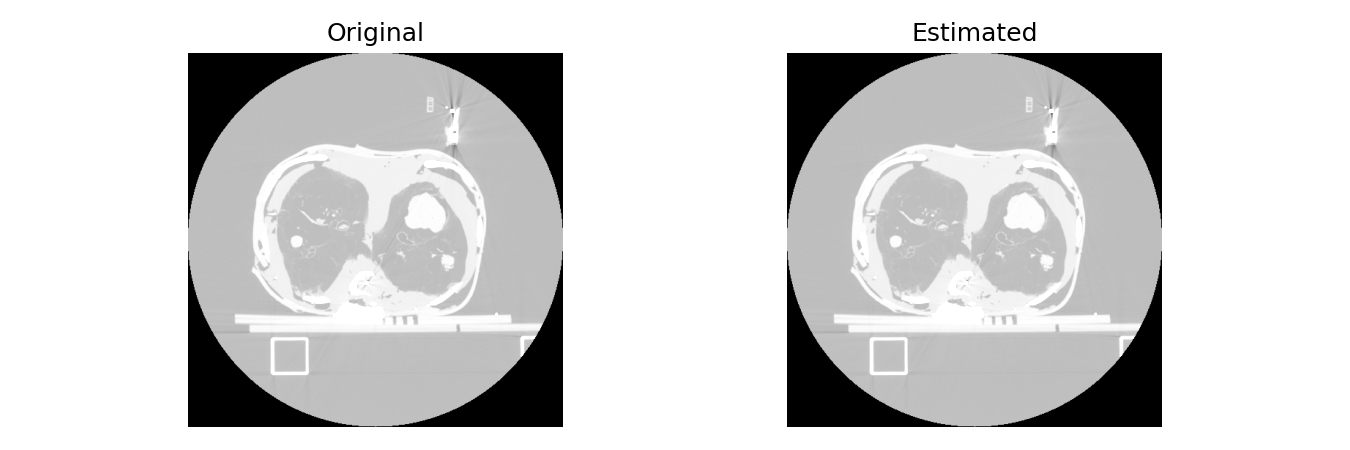

In [9]:
#convert scan to mesh for finding markers via thresholding
scan_file = series_file_names[selected_series]
convert_scan_to_mha(scan_file)# = crop_z)
convert_mha_to_mesh(output_mesh_file = 'temp_mesh.obj', debug=True)
display_Dicom("temp_mesh.mha","temp_mesh.mha")

In [11]:
convert_mha_to_mesh(output_mesh_file = 'temp_mesh2.obj', threshold_value=3000, debug=True)


spacing:  [0.62500392 0.878906   0.878906  ]
image shape in sitk (x,y,z): width 512 then height 512 then depth 256
 origin:  [-149.688 -225.    -225.   ]
numpy version shape: (z,y,x) (256, 512, 512)
locations of different pixels in image [(-225.0, -225.0, -149.688), (224.99987199999998, 224.99987199999998, 10.313003921568622)]
there math https://discourse.itk.org/t/solved-transformindextophysicalpoint-manually/1031/10
perhpas mcubes mirrors?
extreme simple itk pixels: [-960, -978]
extreme simple itk pixels: [-960, -978]
verts shape: (27124, 3)
verts type: <class 'numpy.ndarray'>
Displaying segmented mesh


In [14]:
mesh2 = o3d.io.read_triangle_mesh('temp_mesh2.obj')
mesh2.compute_vertex_normals()

TriangleMesh with 27112 points and 53576 triangles.

In [90]:
o3d.visualization.draw_geometries([mesh2])

In [94]:
# def get_small_clusters(input_mesh, max_area=70, min_area=25):
#     """ Finds largest cluster within the mesh and returns this cluster.
#     Args:
#         input_mesh: input mesh to be clustered and returned. mesh is not
#         modified inside the function. mesh should be an open3d mesh object
#     Returns:
#         An Open3D mesh with only the largest cluster
#     """

aspect_ratios = []
sorted_extents = []
volumes = []

input_mesh = mesh2

#cluster connected triangles
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    triangle_clusters, cluster_n_triangles, cluster_area = (
        input_mesh.cluster_connected_triangles())
triangle_clusters = np.asarray(triangle_clusters)
cluster_n_triangles = np.asarray(cluster_n_triangles)
cluster_area = np.asarray(cluster_area)

for i in range(max(triangle_clusters)):


    #keep largest cluster
    output_mesh = copy.deepcopy(input_mesh)
    triangles_to_remove_large = cluster_area[triangle_clusters]# > max_area
    triangles_to_remove_small = cluster_area[triangle_clusters]# < min_area
    triangles_to_remove = np.logical_or(triangles_to_remove_large, triangles_to_remove_small)

    triangles_to_remove = triangle_clusters!=i
    output_mesh.remove_triangles_by_mask(triangles_to_remove)
    output_mesh.remove_unreferenced_vertices() #very import, removes the extra vertices so we can do the later stuff right!!!

    #    return output_mesh
    obb = output_mesh.get_oriented_bounding_box()
    obb.color = (1, 0, 0)
    
    sorted_extent = np.sort(obb.extent)
    sorted_extents.append(sorted_extent)

    aspect_ratio = sorted_extent[2]/(sorted_extent[0]*sorted_extent[1])
    aspect_ratios.append(aspect_ratio)
    
    #o3d.visualization.draw_geometries([output_mesh,obb])
sorted_extents = np.array(sorted_extents)
aspect_ratios = np.array(aspect_ratios)

[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=172


In [99]:
for i in range(sorted_aspect_ratios.shape[0]):
    if sorted_extents[i,2]>sorted_extents[:,2].mean()+2.5*sorted_extents[:,2].std():
        print(i)
        #keep largest cluster
        output_mesh = copy.deepcopy(input_mesh)
        triangles_to_remove_large = cluster_area[triangle_clusters]# > max_area
        triangles_to_remove_small = cluster_area[triangle_clusters]# < min_area
        triangles_to_remove = np.logical_or(triangles_to_remove_large, triangles_to_remove_small)

        triangles_to_remove = triangle_clusters!=i
        output_mesh.remove_triangles_by_mask(triangles_to_remove)
        output_mesh.remove_unreferenced_vertices() #very import, removes the extra vertices so we can do the later stuff right!!!
        output_mesh.paint_uniform_color([1, 0.706, 0])
        #    return output_mesh
        obb = output_mesh.get_oriented_bounding_box()
        obb.color = (1, 0, 0)

        sorted_extent = np.sort(obb.extent)

        aspect_ratio = sorted_extent[2]/(sorted_extent[0]*sorted_extent[1])
        #aspect_ratios.append(aspect_ratio)

        o3d.visualization.draw_geometries([mesh2,output_mesh,obb])
        


0
85
107


In [101]:
i = 85
output_mesh = copy.deepcopy(input_mesh)
triangles_to_remove_large = cluster_area[triangle_clusters]# > max_area
triangles_to_remove_small = cluster_area[triangle_clusters]# < min_area
triangles_to_remove = np.logical_or(triangles_to_remove_large, triangles_to_remove_small)

triangles_to_remove = triangle_clusters!=i
output_mesh.remove_triangles_by_mask(triangles_to_remove)
output_mesh.remove_unreferenced_vertices() #very import, removes the extra vertices so we can do the later stuff right!!!
output_mesh.paint_uniform_color([1, 0.706, 0])
#    return output_mesh
obb = output_mesh.get_oriented_bounding_box()
obb.color = (1, 0, 0)

sorted_extent = np.sort(obb.extent)

aspect_ratio = sorted_extent[2]/(sorted_extent[0]*sorted_extent[1])
#aspect_ratios.append(aspect_ratio)

o3d.visualization.draw_geometries([mesh2,output_mesh,obb])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [119]:
pcl = output_mesh.sample_points_poisson_disk(number_of_points=5000)
points = np.array(pcl.points)
ind = np.argmin(points[:,2])
tip_point = points[ind]
tip_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=2).translate(tip_point).paint_uniform_color([0.25,0.5,0])
o3d.visualization.draw_geometries([mesh2,pcl,obb,tip_sphere])


array([ 106.44920679, -102.23682983,  -92.98481467])

## Find fiducial centroids in the image

In [15]:
# input_mesh_file = 'temp_mesh.obj't
# mesh = o3d.io.read_triangle_mesh(input_mesh_file)
# mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh])

In [16]:
# def get_small_clusters(input_mesh, max_area=70, min_area=25):
#     """ Finds largest cluster within the mesh and returns this cluster.

#     Args:
#         input_mesh: input mesh to be clustered and returned. mesh is not
#         modified inside the function. mesh should be an open3d mesh object

#     Returns:
#         An Open3D mesh with only the largest cluster

#     """
    
#     #cluster connected triangles
#     with o3d.utility.VerbosityContextManager(
#             o3d.utility.VerbosityLevel.Debug) as cm:
#         triangle_clusters, cluster_n_triangles, cluster_area = (
#             input_mesh.cluster_connected_triangles())
#     triangle_clusters = np.asarray(triangle_clusters)
#     cluster_n_triangles = np.asarray(cluster_n_triangles)
#     cluster_area = np.asarray(cluster_area)

#     #keep largest cluster
#     output_mesh = copy.deepcopy(input_mesh)
#     triangles_to_remove_large = cluster_area[triangle_clusters] > max_area
#     triangles_to_remove_small = cluster_area[triangle_clusters] < min_area
#     triangles_to_remove = np.logical_or(triangles_to_remove_large, triangles_to_remove_small)
#     output_mesh.remove_triangles_by_mask(triangles_to_remove)
#     output_mesh.remove_unreferenced_vertices() #very import, removes the extra vertices so we can do the later stuff right!!!
    
#     return output_mesh
        
        
# def find_candidate_centroids(marker, input_mesh_file = 'temp_mesh.obj', debug=False, diameter_tolerance = 0.5, sphere_fit_rmse_tolerance = 0.25, r_target= 2., min_sphere_cluster_points = 10):
    
#     #load mesh
#     mesh = o3d.io.read_triangle_mesh(input_mesh_file)
#     mesh.compute_vertex_normals()
#     if debug:
#         print("Testing IO for meshes ...")
#         o3d.visualization.draw_geometries([mesh])

#     #keep good sized mesh clusters
#     filter_mesh = get_small_clusters(mesh)

#     #turn mesh into pointcloud
#     points = np.array(filter_mesh.vertices)
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(points)
#     pcd.estimate_normals()

#     #cluster pointcloud
#     with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
#         labels = np.array(
#         pcd.cluster_dbscan(eps=1.5, min_points=10, print_progress=debug))
#     if debug:
#         print(labels.max() )
    
#     max_label = labels.max()  

#     colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
#     colors[labels < 0] = 0
#     pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
#     pcd.estimate_normals()
#     if debug:
#         print(f"point cloud has {max_label + 1} clusters")
#         o3d.visualization.draw_geometries([pcd])

    
#     # find balls good fit quiality and are the right size
#     good_inds = []
#     centroids = []
#     pointcloud_ball_clusters = []
            
#     for i in tqdm.tqdm(range(labels.max()+1)):
#         selected_indices = np.where(labels==i)
#         pcd_selected = pcd.select_by_index(selected_indices[0])
#         points = np.array(pcd_selected.points)

#         if points.shape[0] < 5000:
#             correctX = points[:,0]
#             correctY = points[:,1]
#             correctZ = points[:,2]

#             r, x0, y0, z0, residules = sphereFit(correctX,correctY,correctZ)
#             u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
#             x=np.cos(u)*np.sin(v)*r
#             y=np.sin(u)*np.sin(v)*r
#             z=np.cos(v)*r
#             x = x + x0
#             y = y + y0
#             z = z + z0

#             #See how good this sphere fit is
#             #print(r, x0, y0, z0, residules)
#             errors = []
#             for j in range(len(correctX)):
#                 radius_point = ((correctX[j]-x0)**2+(correctY[j]-y0)**2+(correctZ[j]-z0)**2)**0.5
#                 error = np.abs(radius_point-r)
#                 errors.append(error)
#             errors = np.array(errors)
#             mean_error = np.mean(errors)

#             #print('Mean Error: {}'.format(np.mean(errors)))
#             #print('Radius: {}'.format(r))
#             #good_inds.append(i)

#             #if target_marker == 'marker1':
#             #r_target = r_target_marker_1
#             #if target_marker == 'marker2':
#             #r_target = r_target_marker_2
                
#             #diameter_tolerance = 0.5
#             #sphere_fit_rmse_tolerance = 0.25
#             if mean_error < sphere_fit_rmse_tolerance and r > r_target - diameter_tolerance and r < r_target + diameter_tolerance:
#                 if debug:
#                     print('Mean Error: {}'.format(mean_error))
#                     print('Radius: {}'.format(r))
#                     print('index: {}'.format(i))
#                     o3d.visualization.draw_geometries([copy.deepcopy(pcd_selected).paint_uniform_color([0.8, 0.0, 0.8]),copy.deepcopy(pcd).paint_uniform_color([0, 0.8, 0])])

#                 centroids.append(np.array([x0,y0,z0]))
#                 good_inds.append(i)
#                 pointcloud_ball_clusters.append(pcd_selected)


# #             if debug:
# #                 print(good_inds)
# #                 print(target_marker)
# #                 print('display pointcloud clusters that are a good fit to our target sphere diameter')
# #                 o3d.visualization.draw_geometries(pointcloud_ball_clusters)

    
#     centroid_clusters, pcd_centroid_clusters, o3d_selected_cluster_inds = find_centroid_clusters(centroids,good_inds)

#     if debug:
#         print('pointcloud centroid clusters: {}'.format(pcd_centroid_clusters))
#         print('centroid clusters: {}'.format(centroid_clusters))
#         print(o3d_selected_cluster_inds)
    
#     #find clusters of balls that are close enough to eachother based on the marker geometry
#     good_centroids = o3d_selected_cluster_inds[0]
#     selected_indices = np.where(labels==good_centroids[0])
#     pcd_selected = pcd.select_by_index(selected_indices[0])
    
    
#     good_centroid_clusters = [centroid_cluster for centroid_cluster in centroid_clusters if len(centroid_cluster) >= marker.shape[0]]
#     if debug:
#         print('centroid clustrs: {}'.format(centroid_clusters))
#         print('MEEE good centroid clusters: {}'.format(good_centroid_clusters))

#     for good_centroids in o3d_selected_cluster_inds: #changed 6/22/2022
#         if debug:
#             print('Good centroids: {}'.format(good_centroids))
#         if len(good_centroids) > 0:
#             if debug:
#                 print('Multiple good clusters/centroids found')
#             for i in range(len(good_centroids)): #removed -1 condition!!!!!!!!!! August 16th 2021, not tested with old code...
#                 selected_indices = np.where(labels==good_centroids[i])
#                 if debug:
#                     print('adding cluster: {}'.format(i))
#                 pcd_selected += pcd.select_by_index(selected_indices[0]) #this adds the full cluster of points. index 0 is to get rid of the list wrapper

#     pcd_selected.paint_uniform_color([0.8, 0.0, 0.8])

#     if debug:
#         o3d.visualization.draw_geometries([pcd_selected])


#     if debug:
#         print("Downsample the point cloud with a voxel of 0.05")
#     marker_centroid_coordinates_list = []
#     marker_centroid_coordinates = []

#     for i in range(len(good_centroid_clusters)):
#         local_marker_coordinates = good_centroid_clusters[0][i]# - base_centroid
#         marker_centroid_coordinates.append(local_marker_coordinates)

#     marker_centroid_coordinates = np.array(marker_centroid_coordinates).squeeze()
#     if debug:
#         print('centroid coordinates: {}'.format(marker_centroid_coordinates))
#     mean_centroid_coordinates = np.mean(np.array(pcd_selected.points), axis=0)
    
#     if debug:
#         print('mean centroid coodinates: {}'.format(mean_centroid_coordinates))
#         print('marker_centroid_coordinates: {}'.format(marker_centroid_coordinates))
#         print('marker_centroid_coordinates_list: {}'.format(marker_centroid_coordinates_list))

#     coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10.0, origin=marker.mean(axis=0))#mean_centroid_coordinates)

#     if debug:
#         print('marker: {}'.format(marker))
    
#     return copy.deepcopy(marker), copy.deepcopy(marker_centroid_coordinates), copy.deepcopy(pcd_selected), copy.deepcopy(mesh), copy.deepcopy(coordinate_frame), np.array(good_centroid_clusters)#, np.array(marker_centroid_coordinates_list)



In [17]:
# mesh2 = get_small_clusters(mesh)
# o3d.visualization.draw_geometries([mesh2])

# #cluster connected triangles
# # with o3d.utility.VerbosityContextManager(
# #         o3d.utility.VerbosityLevel.Debug) as cm:
# #     triangle_clusters, cluster_n_triangles, cluster_area = (
# #         mesh2.cluster_connected_triangles())
# # triangle_clusters = np.asarray(triangle_clusters)
# # cluster_n_triangles = np.asarray(cluster_n_triangles)
# # cluster_area = np.asarray(cluster_area)

# # print(triangle_clusters)
# # print(cluster_n_triangles)
# # print(cluster_area)

# # o3d.visualization.draw_geometries([mesh2])

# # #keep largest cluster
# # output_mesh = copy.deepcopy(mesh2)
# # #triangles_to_remove = cluster_area[triangle_clusters] > max_area
# # #output_mesh.remove_triangles_by_mask(triangles_to_remove)
# # i = 10
# # indices = np.where(triangle_clusters==i)[0]
# # print(indices)
# # temp_mesh = output_mesh.select_by_index(indices)
# # o3d.visualization.draw_geometries([temp_mesh])

# mypoints = np.array(mesh2.vertices)
# mypcd = o3d.geometry.PointCloud()
# mypcd.points = o3d.utility.Vector3dVector(mypoints)
# mypcd.estimate_normals()
# if debug:
#     o3d.visualization.draw_geometries([mypcd])


In [18]:
#find candidate fiducials within the scanner returning clustered centroids that could be rigid body markers
_, marker_centroid_coordinates, pcd_selected, marker_mesh, _, good_centroid_clusters = find_candidate_centroids(marker = marker, debug=False)

print('marker centroid coordinates from design: {}'.format(marker))
print('found centroid coordinates: {}'.format(marker_centroid_coordinates))

#display candidate fiducials
o3d.visualization.draw_geometries([pcd_selected, marker_mesh])

[Open3D DEBUG] [ClusterConnectedTriangles] Compute triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done computing triangle adjacency
[Open3D DEBUG] [ClusterConnectedTriangles] Done clustering, #clusters=383
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 26


100%|█████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 604.64it/s]


[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 3
point cloud has 3 clusters
marker centroid coordinates from design: [[-10  -5   0]
 [-10   5   0]
 [  0  -5   0]
 [ 10   0   0]]
found centroid coordinates: [[ 130.95868863   82.83222744 -120.32601684]
 [ 153.37030891   82.40006021 -117.30546681]]


## Find marker

In [ ]:
import tqdm

In [166]:
import random

def calculate_transform(num_markers,centroids,marker_geometry, verbose=False):
    '''
    function to find the transfrom info of the input assuming correct centroids but without correspondance being solved
    input:
        num_markers: number of markers in the target rigid body (float)
        centroids: centroid locations of rigid body found in image (Nx3, numpy, millimeters)
        marker_geometry: centroid locations of rigid body manufacturered (Nx3, numpy, millimeters)
    return:
        final_R: solved rotation matrix
        final_t: solved translation vector
        permuted_centroids: new centroid locations permuted for minimum transform error
        min_error: rmse reconstruction error
    '''

    centroids = centroids.copy()
    marker_geometry = marker_geometry.copy()
    centroids_SE3 = np.vstack((centroids.T, np.ones(num_markers)))
   

    ret_R, ret_t = rigid_transform_3D(marker_geometry, centroids_SE3[:3,:])
    B2 = (ret_R@marker_geometry) + ret_t
    err = B2 - centroids_SE3[:3,:]
    err = err * err
    err = np.sum(err)
    rmse = np.sqrt(err/len(marker_geometry[0]))
    final_R = ret_R
    final_t = ret_t
    permuted_centroids = centroids_SE3[:3,:]

    if verbose:
        if min_error < 10:
            print("Everything looks good!")
            #print("the final error is: ",min_error)
        else:
            print("Hmm something doesn't look right ...")
    return final_R,final_t, permuted_centroids, rmse

def RANSAC_find_best_transform_from_candidate_marker_clusters(marker, good_centroid_clusters,debug=False):
    '''
    find best (lowest reconstruction error) marker set in each rigid body (if multiple)
    inputs: 
        marker
        good_centroid_clusters
    returns:
        final_R
        final_t
        permuted_centroids
        err
    '''
    num_markers = marker.shape[0]

    R_list = []
    t_list = []
    permuted_centroids_list = []
    permuted_centroids_base_list = []
    error_list = []
    for n in range(num_markers-3):
        num_markers_to_use = num_markers-n
        print(num_markers_to_use)
        segmented_marker = list(good_centroid_clusters)
        base_marker = list(marker)

        for i in tqdm.tqdm(range(100000)):            
            sampled_marker = random.sample(segmented_marker, num_markers_to_use)
            sampled_marker = np.array(sampled_marker)
            
            sampled_base_marker = random.sample(base_marker, num_markers_to_use)
            sampled_base_marker = np.array(sampled_base_marker)
            
            #print(sampled_marker)
            #print(sampled_base_marker)

            final_R, final_t, permuted_centroids, error = calculate_transform(num_markers_to_use, sampled_marker, sampled_base_marker.T)
            R_list.append(final_R)
            t_list.append(final_t)
            permuted_centroids_list.append(permuted_centroids)
            permuted_centroids_base_list.append(sampled_base_marker)
            error_list.append(error)
            
            if np.linalg.norm(error)<0.1:
                print('found good transform early so stopping, reprojection error: {}'.format(error))
                break

    error_list = np.array(error_list)
    if debug:
        print(error_list)
    #print(R_list)
    #print(t_list)
    #print(permuted_centroids_list)
    min_error = np.amin(error_list)
    min_error_index = np.argmin(error_list)
    max_error = np.amax(error_list)
    max_error_index = np.argmax(error_list)
    #rint(min_error_index)
    final_R = R_list[min_error_index]
    final_t = t_list[min_error_index]
    permuted_centroids = permuted_centroids_list[min_error_index]
    permuted_centroids_base = permuted_centroids_base_list[min_error_index]

    if min_error < 10:
        print("Everything looks good!")
        if debug:
            print("the final error is: ",min_error)
    else:
        print("Hmm something doesn't look right ...")

    return final_R, final_t, permuted_centroids, permuted_centroids_base, min_error


In [167]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [168]:
#find best transform and marker from candidate fiducials
tracked_R, tracked_t, permuted_centroids, permuted_centroids_base, min_error = RANSAC_find_best_transform_from_candidate_marker_clusters(marker, flatten(good_centroid_clusters))

#get rid of column of ones to make 3xN
permuted_centroids = permuted_centroids[:3,:].T
permuted_centroids_base = permuted_centroids_base[:,:3]

print(permuted_centroids)
print(permuted_centroids_base)

#transform marker geometry coordinates using found transform to tracked image coordinates
transformed_marker = (tracked_R @ permuted_centroids_base.T + tracked_t).T
error = permuted_centroids-transformed_marker

print(error)

4


  9%|██████▋                                                                   | 8966/100000 [00:00<00:10, 8997.72it/s]


found good transform early so stopping, reprojection error: 0.03263576194603603
Everything looks good!
[[ 101.38 -126.81  -91.41]
 [ 101.78 -126.54  -81.46]
 [ 105.89 -127.04 -101.64]
 [ 111.84 -126.51  -81.95]]
[[  0  -5   0]
 [-10  -5   0]
 [ 10   0   0]
 [-10   5   0]]
[[ 0.02 -0.    0.03]
 [-0.04  0.   -0.01]
 [ 0.    0.    0.01]
 [ 0.02 -0.   -0.03]]


## Visualize Marker

In [172]:
#create o3d visualizations
marker_3d_tracked = create_marker_visualization(fiducial_coordinates=permuted_centroids, color=[0.8, 0.2, 0.2])
marker_3d_base = create_marker_visualization(permuted_centroids_base, [0.2, 0.8, 0.2])
marker_3d_base.append(create_coordinate_frame_visualization())
marker_3d_transformed = create_marker_visualization(permuted_centroids_base, [0.2, 0.2, 0.8], tracked_R, tracked_t)
marker_3d_transformed.append(create_coordinate_frame_visualization(tracked_R, tracked_t))

#display tracked  markers and coordinate frames
# o3d.visualization.draw_geometries(marker_3d_tracked)
# o3d.visualization.draw_geometries(marker_3d_base)
# o3d.visualization.draw_geometries(marker_3d_transformed)



In [182]:
#tracking error from final transform
np.set_printoptions(2)
print("Error (mm): {}".format(error))
print("Error norm (mm): {}".format(np.linalg.norm(error,axis=1).mean()))

#visualize tracked markers on top of mesh used for tracking
visualization_list2 = marker_3d_tracked+marker_3d_base+marker_3d_transformed + [marker_mesh]
#visualization_list1 = copy.deepcopy(visualization_list2)
o3d.visualization.draw_geometries(visualization_list2)

visualizations.append(copy.deepcopy(visualization_list2))

Error (mm): [[ 0.02 -0.    0.03]
 [-0.04  0.   -0.01]
 [ 0.    0.    0.01]
 [ 0.02 -0.   -0.03]]
Error norm (mm): 0.03064772919161378


In [176]:
convert_mha_to_mesh(output_mesh_file = 'temp_mesh2.obj', threshold_value = 100, debug=True)


spacing:  [0.63 0.88 0.88]
image shape in sitk (x,y,z): width 512 then height 512 then depth 256
 origin:  [-149.69 -225.   -225.  ]
numpy version shape: (z,y,x) (256, 512, 512)
locations of different pixels in image [(-225.0, -225.0, -149.688), (224.99987199999998, 224.99987199999998, 10.313003921568622)]
there math https://discourse.itk.org/t/solved-transformindextophysicalpoint-manually/1031/10
perhpas mcubes mirrors?
extreme simple itk pixels: [-960, -978]
extreme simple itk pixels: [-960, -978]
verts shape: (1664678, 3)
verts type: <class 'numpy.ndarray'>
Displaying segmented mesh


In [178]:
mesh2 = o3d.io.read_triangle_mesh('temp_mesh2.obj')
mesh2.compute_vertex_normals()
o3d.visualization.draw_geometries(visualization_list2+[mesh2])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [131]:
scan_0_dict = {
    #"o3d" : scan0,
    "T" : transforms[0]
}

scan_3_dict = {
    #"o3d" : scan3,
    "T" : transforms[3]
}

scan_1_dict = {
    #"o3d" : scan1,
    "T" : transforms[1]
}

scan_4_dict = {
    #"o3d" : scan4,
    "T" : transforms[4]
}


scans_dict = {
    'motion1, scan0': scan_0_dict,
    'motion2, scan3': scan_3_dict,
    'motion3, scan1': scan_1_dict,
    'motion4, scan4': scan_4_dict,
}

In [132]:
scans_dict

{'motion1, scan0': {'T': array([[-9.99e-01, -4.75e-02, -2.61e-02, -7.88e+01],
         [-2.62e-02,  2.90e-03,  1.00e+00, -1.39e+02],
         [-4.74e-02,  9.99e-01, -4.14e-03,  9.51e+01],
         [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]])},
 'motion2, scan3': {'T': array([[-9.99e-01, -4.74e-02, -2.43e-02, -7.88e+01],
         [-2.44e-02,  1.92e-03,  1.00e+00, -1.27e+02],
         [-4.73e-02,  9.99e-01, -3.08e-03,  9.51e+01],
         [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]])},
 'motion3, scan1': {'T': array([[-9.99e-01, -4.76e-02, -2.66e-02, -7.95e+01],
         [-2.68e-02,  3.36e-03,  1.00e+00, -1.27e+02],
         [-4.75e-02,  9.99e-01, -4.63e-03,  1.07e+02],
         [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]])},
 'motion4, scan4': {'T': array([[-9.99e-01, -4.71e-02, -2.61e-02, -9.18e+01],
         [-2.63e-02,  2.60e-03,  1.00e+00, -1.27e+02],
         [-4.70e-02,  9.99e-01, -3.83e-03,  1.06e+02],
         [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]])}}

In [115]:
o3d.visualization.draw_geometries(scan1+scan3 + scan0 + scan4)

In [116]:
print('Transform 0: {}\n Transform 3: {}\n Transform 1: {}\n + Transform 4: {}'.format(transforms[0], transforms[3], transforms[1], transforms[4]))

Transform 0: [[-9.99e-01 -4.75e-02 -2.61e-02 -7.88e+01]
 [-2.62e-02  2.90e-03  1.00e+00 -1.39e+02]
 [-4.74e-02  9.99e-01 -4.14e-03  9.51e+01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
 Transform 3: [[-9.99e-01 -4.74e-02 -2.43e-02 -7.88e+01]
 [-2.44e-02  1.92e-03  1.00e+00 -1.27e+02]
 [-4.73e-02  9.99e-01 -3.08e-03  9.51e+01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
 Transform 1: [[-9.99e-01 -4.76e-02 -2.66e-02 -7.95e+01]
 [-2.68e-02  3.36e-03  1.00e+00 -1.27e+02]
 [-4.75e-02  9.99e-01 -4.63e-03  1.07e+02]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
 + Transform 4: [[-9.99e-01 -4.71e-02 -2.61e-02 -9.18e+01]
 [-2.63e-02  2.60e-03  1.00e+00 -1.27e+02]
 [-4.70e-02  9.99e-01 -3.83e-03  1.06e+02]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]


In [119]:
!pip install cloudpickle

In [133]:
import cloudpickle

with open('accuracy_data_crane_07_27_scan.pkl', mode='wb') as file:
   cloudpickle.dump(scans_dict, file)


with open('accuracy_data_crane_07_27_scan.pkl', mode='rb') as file:
   instance = cloudpickle.load(file)

In [134]:
print(instance)

{'motion1, scan0': {'T': array([[-9.99e-01, -4.75e-02, -2.61e-02, -7.88e+01],
       [-2.62e-02,  2.90e-03,  1.00e+00, -1.39e+02],
       [-4.74e-02,  9.99e-01, -4.14e-03,  9.51e+01],
       [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]])}, 'motion2, scan3': {'T': array([[-9.99e-01, -4.74e-02, -2.43e-02, -7.88e+01],
       [-2.44e-02,  1.92e-03,  1.00e+00, -1.27e+02],
       [-4.73e-02,  9.99e-01, -3.08e-03,  9.51e+01],
       [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]])}, 'motion3, scan1': {'T': array([[-9.99e-01, -4.76e-02, -2.66e-02, -7.95e+01],
       [-2.68e-02,  3.36e-03,  1.00e+00, -1.27e+02],
       [-4.75e-02,  9.99e-01, -4.63e-03,  1.07e+02],
       [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]])}, 'motion4, scan4': {'T': array([[-9.99e-01, -4.71e-02, -2.61e-02, -9.18e+01],
       [-2.63e-02,  2.60e-03,  1.00e+00, -1.27e+02],
       [-4.70e-02,  9.99e-01, -3.83e-03,  1.06e+02],
       [ 0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00]])}}


In [129]:
!pip install dill

## Visualize tracked markers and full scan w/ low threshold

convert_scan_to_mha(scan_file_CRANE)
convert_mha_to_mesh(output_mesh_file = 'temp_full_mesh.stl', threshold_value = -400, debug=False)
temp_full_mesh = o3d.io.read_triangle_mesh('temp_full_mesh.stl').paint_uniform_color([0.0, 0.0, 0.8]).compute_vertex_normals()

o3d.visualization.draw_geometries(visualization_list2+[temp_full_mesh])



In [171]:
#find full scan and body mesh (largest cluster)
full_remeshed = load_and_remesh('temp_full_mesh.stl')
o3d.visualization.draw_geometries(visualization_list2+[full_remeshed])

#largest cluster mesh which is typically the body
body_mesh = get_largest_mesh_cluster(full_remeshed)
o3d.visualization.draw_geometries(visualization_list2+[body_mesh])

[Open3D WARNING] Unable to load file temp_full_mesh.stl with ASSIMP


RuntimeError: [Open3D Error] (class std::tuple<class std::shared_ptr<class open3d::geometry::TriangleMesh>,class std::vector<double,class std::allocator<double> > > __cdecl open3d::geometry::TriangleMesh::CreateFromPointCloudPoisson(const class open3d::geometry::PointCloud &,unsigned __int64,float,float,bool,int)) D:\a\Open3D\Open3D\cpp\open3d\geometry\SurfaceReconstructionPoisson.cpp:753: [CreateFromPointCloudPoisson] pcd has no normals


#find full scan and body mesh (largest cluster)
full_remeshed = load_and_remesh('temp_full_mesh.stl')
o3d.visualization.draw_geometries(visualization_list2+[full_remeshed])

#largest cluster mesh which is typically the body
body_mesh = get_largest_mesh_cluster(full_remeshed)
o3d.visualization.draw_geometries(visualization_list2+[body_mesh])

body_mesh = get_largest_mesh_cluster(full_remeshed)


o3d.visualization.draw_geometries(visualization_list2+[body_mesh])
#o3d.io.write_triangle_mesh('body.stl', body_mesh)

body_smpl = body_mesh.simplify_quadric_decimation(target_number_of_triangles=10000)


output_mesh = body_smpl+marker_3d_base[-1]
o3d.visualization.draw_geometries([output_mesh])

o3d.io.write_triangle_mesh('body_smpl.stl', output_mesh)

mesh2 = o3d.io.read_triangle_mesh('body_smpl.stl')
frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=20)
o3d.visualization.draw_geometries([mesh2,frame])


np.set_printoptions(precision=4)

print(tracked_R.T)
print(-tracked_R.T@tracked_t/1000)

np.set_printoptions(precision=4)

print(tracked_R.T)
print(-tracked_R.T@tracked_t/1000)

np.set_printoptions(precision=4)

print(tracked_R.T)
print(-tracked_R.T@tracked_t/1000)

###### 

## What we need to do for tracking error vs. setpoint:

Used known marker geometry
Place coordinate frame in the middle of the known marker.

Process CT scan and find the marker. Find transform from known marker geometry to scan.

$T^{scn}_{mrk}$. We also have the mesh already in the scanner frame with origin at scanner origin --> $T^{scn}_{mesh}$

We want to bring the mesh into the Coppellia Sim. We know $T^{rb}_{magmrk}$ from the magnetic tracker.

Robot base transform to scanner transform is: $T^{rb}_{scn} = T^{rb}_{magmrk} T^{mrk}_{scn}$

So we can get the mesh in robot frame as: $T^{rb}_{mesh} =  T^{rb}_{scn} T^{scn}_{mesh}$

We also need to find the robot itself in the image frame to get an error term.

Let say we have a target needle insertion pose in the scanner frame $T^{rb}_{tnt} = T^{rb}_{scn} T^{scn}_{tnt}$, we can get that to the robot frame using the calibration. Lets say we know need to find our error. Assume static robot to scanner transform.

We have another marker on the robot we track giving $T^{scn}_{eemrk}$ which we can use to calculate $T^{rb}_{eemrk} = T^{rb}_{scn} T^{scn}_{eemrk}$ and magnetic tip marker or FK giving $T^{rb}_{ee}$ then we can get the robot error as: $\Delta T = (T^{rb}_{tnt})^{-1} T^{rb}_{eemrk}$

## Taking tracking error to control:

From this, we can calculate a new robot setpoint pose for IK by right multiplying this transform to the current value we are controlling for